In [74]:
%load_ext autoreload

%autoreload 2
import sys
import corner
import numpy as np
import unbinned_likelihood
import matplotlib.pyplot as plt
import scipy
import astropy.units as u
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
import utils
import pandas as pd
import abundance as cl_count
import forecast
import emcee
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/mcmc_modules')
import unbinned_model as ub
from lnlikelihood import lnLikelihood
import pyccl as ccl
import edit
import h5py, glob
from astropy.coordinates import SkyCoord
from astropy.table import Table
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# Data
fsky_default = 1/4
fsky = fsky_default/3
fsky = 0.05 
print(100*fsky)
theta_aperture = np.arccos(1-2*fsky)*180/np.pi

5.0


In [76]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)
cat_test = pd.read_csv(cat[35] ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777
#select in aperture
ra_center, dec_center = 180, 60
cat_center_SkyCoord =SkyCoord(ra=np.array([ra_center])*u.degree, dec=np.array([dec_center])*u.degree)
pos_ra, pos_dec = cat_test['ra'], cat_test['dec']
cat_pinocchio_SkyCoord=SkyCoord(ra=np.array(pos_ra)*u.degree, dec=np.array(pos_dec)*u.degree)
idxcat_center, idxcat_pinocchio, d2d, d3d = cat_center_SkyCoord.search_around_sky(cat_pinocchio_SkyCoord, theta_aperture*u.deg)
#resize catalog
cat_test = Table.from_pandas(cat_test)[idxcat_center]
raa, decc, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777

In [77]:
mask = (redshift > .2)&(redshift < .5)
mask = mask &(np.log10(Mvir) > 14.7)&(np.log10(Mvir) < 15.6)
redshift_cut = redshift[mask]
Mvir_cut = Mvir[mask]

In [78]:
Nobs = len(Mvir_cut)
z_sample = redshift_cut
logm_sample = np.log10(Mvir_cut)

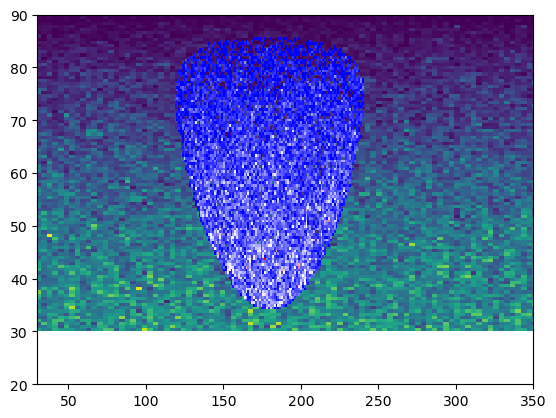

In [79]:
plt.hist2d(ra, dec,bins=100)
plt.hist2d(raa, decc,bins=100, cmap = 'bwr', cmin=1)
plt.xlim(30, 350)
plt.ylim(20, 90)
plt.show()

In [80]:
# model

In [81]:
cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
mapping = ub.Mapping()
mapping.set_cosmology(cosmo)
z_grid = np.linspace(.2, .5, 500)
logm_grid = np.linspace(14.7, 15.6, 501)
dN_dlogmdz_map = mapping.compute_dN_dlogMdzdOmega_map(z_grid, logm_grid, fsky)
sigma2_map = mapping.compute_sigma2_map(z_grid, fsky)
halo_bias_map = mapping.compute_halo_bias_map(z_grid, logm_grid)

In [95]:
def model(i):
    mapping = ub.Mapping()
    cosmo = ccl.Cosmology(Omega_c = Om_tab[i] - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
    mapping.set_cosmology(cosmo)
    dN_dlogmdz_map = mapping.compute_dN_dlogMdzdOmega_map(z_grid, logm_grid, fsky)
    #halo_bias_map = mapping.compute_halo_bias_map(z_grid, logm_grid)
    #sigma2_map = mapping.compute_sigma2_map(z_grid, fsky)
    mapping.interp(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, )
    Nth = mapping.compute_N_th(z_grid, logm_grid, dN_dlogmdz_map)
    NNSbb_thth = mapping.compute_NNSbb_thth(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, Nth)
    mapping.create_reduced_sample( z_sample, logm_sample, n_samples =2000)
    NNSbb_obsobs = mapping.compute_NNSbb_obsobs(z_grid, logm_grid, 
                                        sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                                        z_sample, logm_sample, Nobs, reduced_sample = False)
    NNSbb_obsth = mapping.compute_NNSbb_obsth(z_grid, logm_grid, 
                                        sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                                        z_sample, logm_sample, Nth, Nobs, reduced_sample = False)
    NSb2_obs = mapping.compute_NSb2_obs(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                                        z_sample, logm_sample, Nth, Nobs, reduced_sample = False)
    dN_dzdlogM = mapping.N_map_interp_fct(logm_sample, z_sample, grid = False)
    rSNSSC = unbinned_likelihood.lnLikelihood_UnBinned_Poissonian_SSC(dN_dzdlogM, Nth, Nobs,
                                     NNSbb_obsobs,
                                     NNSbb_obsth,
                                     NNSbb_thth,
                                     NSb2_obs)
    rSN = unbinned_likelihood.lnLikelihood_UnBinned_Poissonian(dN_dzdlogM, Nth,)
    return NNSbb_thth, NNSbb_obsobs, NNSbb_obsth, NSb2_obs, rSNSSC, rSN

In [96]:
Om_tab = np.linspace(0.2, 0.4, 20)

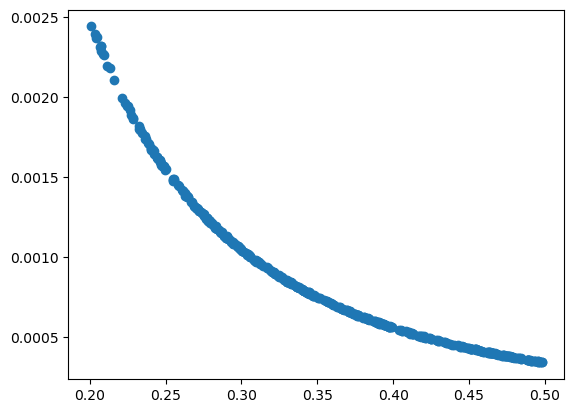

In [93]:
NNSbb_thth, NNSbb_obsobs, NNSbb_obsth, NSb2_obs, rSNSSC, rSN = model(0)

In [94]:
1 + 0.5*(NNSbb_thth - 2*NNSbb_obsth +NNSbb_obsobs-NSb2_obs)

18.041706717656808

In [73]:
NSb2_obs

15.097919630143455